# Lecture 4

Some concepts from Lecture 4 2022 (https://www.youtube.com/watch?v=QiHKdvAbYII) are not present in Chapter 4

In [5]:
import pandas as pd
from plotnine import ggplot, aes, facet_grid, labs, geom_point, theme_dark, geom_line, theme, geom_histogram, geom_density, geom_histogram,stat_density, xlab
import pymc3 as pm
import numpy as np

In [6]:
howell = pd.read_csv('./data/howell1.csv', sep=';')

In [7]:
howell = howell[howell['age']>18]

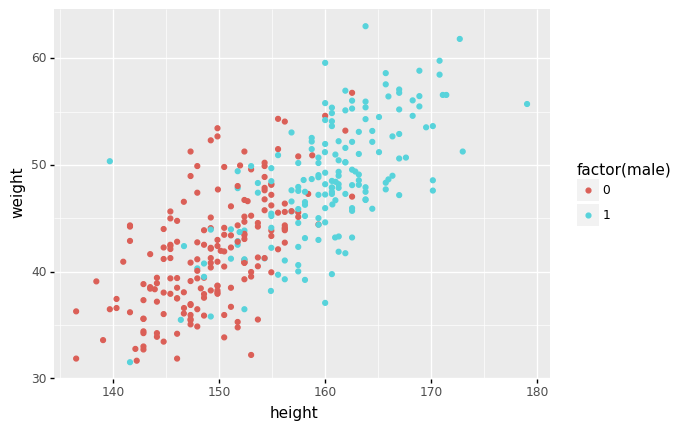

<ggplot: (307610832)>

In [8]:
(ggplot(howell, aes(x='height', y='weight', color='factor(male)'))
            + geom_point())

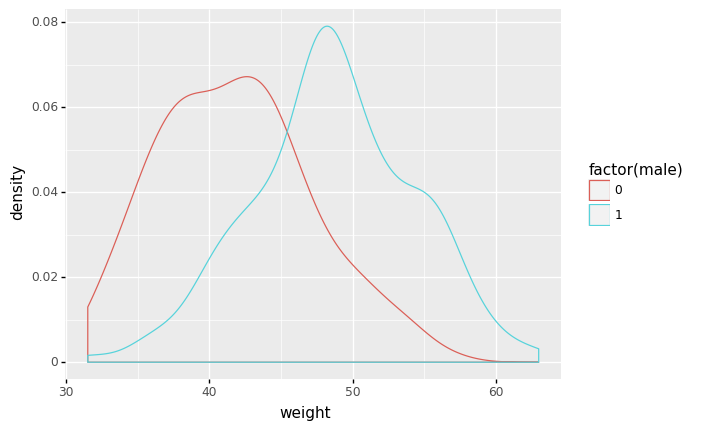

<ggplot: (308007449)>

In [9]:
(ggplot(howell, aes(x='weight', color='factor(male)'))
            + stat_density())

H height
W weight
S sex

Causal model: Sex affects both H and W. H affects W


Questions:
    Effect of H on W?
    Effect of S on W?
    Dirrect effect of S on W?
    

# Effect on S on W

In [10]:
howell.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


`normal_per_s` uses dummy variables, how to do this with index variables?

In [67]:
with pm.Model() as normal_per_s:
    sigma = pm.Uniform('sigma',0,10)
    alpha = np.array([pm.Normal('alpha_1',60,100), pm.Normal('alpha_2', 60,100)])
    mus = pm.Deterministic("mus", alpha[0] * howell.male + alpha[1] * howell.male)
    a = pm.Normal('alpha', mu=mus, sigma=sigma, observed = howell.weight)
    trace = pm.sample()
    prior_samples = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=['alpha'])

/Users/ciguaran/personal/statistical_rethinking/charleemos_dec/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_2, alpha_1, sigma]
INFO:pymc3:NUTS: [alpha_2, alpha_1, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.
There were 321 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 321 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5685976965503226, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [23]:
trace_as_df = pm.trace_to_dataframe(trace)

In [28]:
trace_as_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Columns: 350 entries, alpha_1 to diff
dtypes: float64(350)
memory usage: 10.7 MB


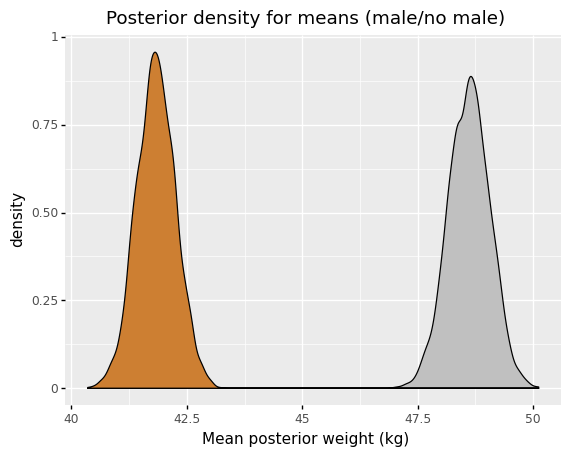

<ggplot: (310888455)>

In [24]:
(ggplot(trace_as_df) 
 + stat_density(aes(x='alpha_1'), fill = '#C0C0C0') 
 + stat_density(aes(x='alpha_2'), fill = '#cd7f32') 
 + labs(title="Posterior density for means (male/no male)")
 + xlab("Mean posterior weight (kg)"))

# Contrast

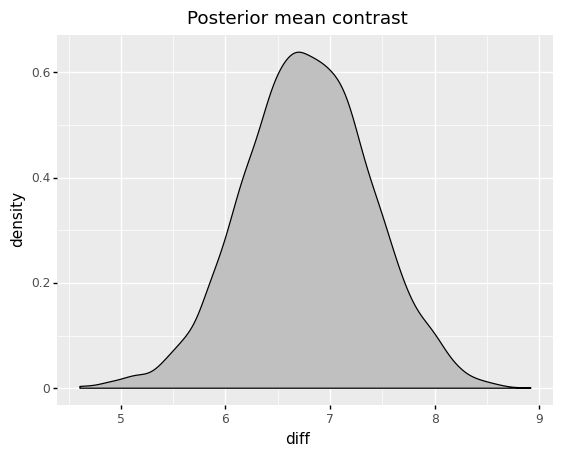

<ggplot: (310905363)>

In [26]:
trace_as_df['diff'] = trace_as_df['alpha_1'] - trace_as_df['alpha_2']
(ggplot(trace_as_df) 
 + stat_density(aes(x='diff'), fill = '#C0C0C0') 
 + labs(title="Posterior mean contrast"))

In [33]:
posterior_predictive['alpha_1'] - posterior_predictive['alpha_2'] 

array([6.32643384, 6.46290486, 6.99342205, ..., 7.46744132, 7.48118522,
       7.00865959])

In [53]:
from scipy.stats import norm
simulated_males = norm(trace_as_df['alpha_1'], trace_as_df['sigma']).rvs()
simulated_no_males = norm(trace_as_df['alpha_2'], trace_as_df['sigma']).rvs()
posterior_simulation = pd.DataFrame({'simulated_males': simulated_males, 'simulated_no_males': simulated_no_males})
posterior_simulation['Posterior weight contrast'] = posterior_simulation['simulated_males'] - posterior_simulation['simulated_no_males']

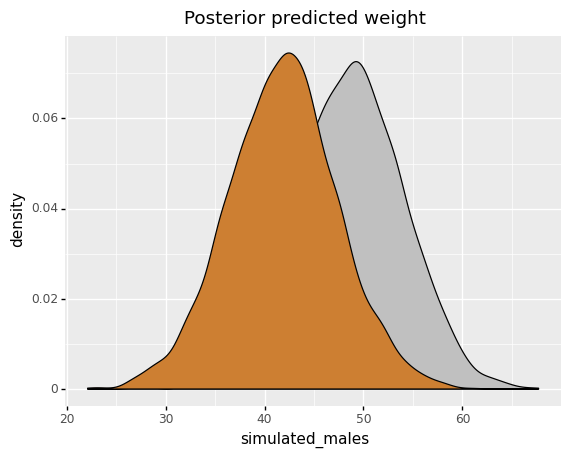

<ggplot: (312252784)>

In [54]:
(ggplot(posterior_simulation)
 + stat_density(aes(x='simulated_males'), fill = '#C0C0C0') 
  + stat_density(aes(x='simulated_no_males'), fill = '#cd7f32')
 + labs(title="Posterior predicted weight"))

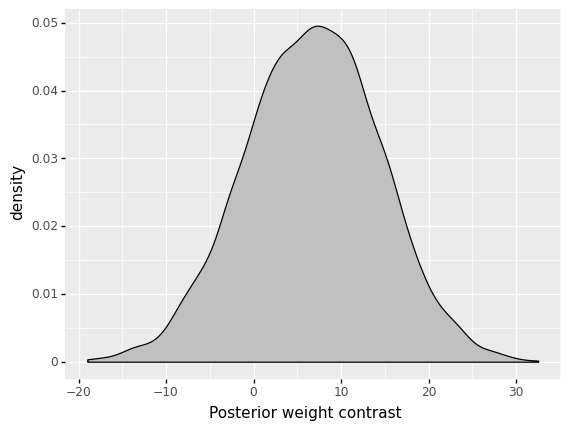

<ggplot: (312536432)>

In [56]:
(ggplot(posterior_simulation)
 + stat_density(aes(x='Posterior weight contrast'), fill = '#C0C0C0')
)

Below 0 means no male are taller. > 0 contrary case.

Using pymc's posterior_predictive

In [62]:
posterior_predictive 

{'alpha': array([[50.57940068, 42.64751177, 37.22592085, ..., 51.21788596,
         41.03682431, 51.92758623],
        [46.42556841, 38.99910275, 50.48836996, ..., 51.16876726,
         47.32502682, 44.17154919],
        [44.89575245, 45.34304773, 47.70482319, ..., 42.32725455,
         35.95220596, 53.36267242],
        ...,
        [47.94697004, 42.83810385, 37.87595653, ..., 51.52123234,
         36.19450609, 43.73374694],
        [50.0465262 , 43.48278474, 41.72146139, ..., 44.9915609 ,
         42.84362794, 39.69586246],
        [41.13279619, 36.95054166, 34.66430969, ..., 54.46194011,
         42.39189117, 61.71514818]])}

In [ ]:
So far, we haven't included Height on the model. From these we have been able to estimate the causal effect of S over W. Posterior mean contrast
and posterior weight constrast.

# Direct effect of S on W

This involves considering weight 

In [73]:
mean_height = np.mean(howell.height)
with pm.Model() as including_height:
    sigma = pm.Uniform('sigma',0,10)
    alphas = np.array([pm.Normal('alpha_1',60,100), pm.Normal('alpha_2', 60,100)])
    betas = np.array([pm.Lognormal('beta_1',0,1), pm.Lognormal('beta_2', 0,1)])
    alpha = pm.Deterministic("alpha", alphas[0] * howell.male + alphas[1] * (1-howell.male))
    beta = pm.Deterministic("beta", betas[0] * howell.male + betas[1] * (1-howell.male))
    regression = pm.Deterministic("regression", alpha + beta * (howell.height-mean_height))
    a = pm.Normal('weight', mu=regression, sigma=sigma, observed = howell.weight)
    trace = pm.sample()

/Users/ciguaran/personal/statistical_rethinking/charleemos_dec/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_2, beta_1, alpha_2, alpha_1, sigma]
INFO:pymc3:NUTS: [beta_2, beta_1, alpha_2, alpha_1, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


In [ ]:
trace[]